# Expanded recharge map for the TRCA

## Recharge
The latest official regional recharge estimation was the so-called York Tier-3 model [YT3 (2013)](https://www.ctcswp.ca/app/uploads/2017/05/RPT_201311_Earthfx_York_Tier3WBLocAreaRiskAssFNL.pdf). Part of the delivered model package was the long-term average recharge (mm/yr) which was applied (as model input) to the steady-state groundwater flow model used for source water protection planning.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model 
from pyGrid import definition

In [2]:
gdYT3 = definition.GDEF("M:/model_archive/0018/10_operational_model/YT3ss.gdef", prnt=False)
rch = gdYT3.LoadBinary("M:/model_archive/0018/10_operational_model/YT3_Earthfx_ss_mm/VL-YT3ss_RCH.grd", False)
rch *= 365.25*1000.
rch.tofile("raster/VL-YT3ss_RCH.bil")
gdYT3.saveBitmap("img/VL-YT3ss_RCH.png", rch)

![](img/VL-YT3ss_RCH.png)

Set to TEGWFM18 grid definition

In [3]:
gdTEGWFM18 = definition.GDEF("O:/internal/TRCA/TEGWFM18/TRCA_expansion.gdef", prnt=False)

rchTEGWFM18 = np.full(shape=gdTEGWFM18.shape(),fill_value=-9999,dtype=np.float32)
rchTEGWFM18[:897, 30:870] = rch[3:900,:840]
rchTEGWFM18.tofile("raster/VL-YT3ss_RCH_gdTEGWFM18.bil")
gdTEGWFM18.saveBitmap("img/VL-YT3ss_RCH_gdTEGWFM18.png",rchTEGWFM18)

![](img/VL-YT3ss_RCH_gdTEGWFM18.png)

![]("VL-YT3ss_RCH_gdTEGWFM18.png)

## Land use mapping

*below adopted from OWRC-SWS.ipynb*

The source of the land use data is: *Ministry of Natural Resources and Forestry, 2019. Southern Ontario Land Resource Information System (SOLRIS) Version 3.0: Data Specifications. Science and Research Branch, April 2019.*

The SOLRIS data has already been transformed to a 25,000x25,000, 10m grid that is here up-scaled to a 2500x2500, 100m grid. The following code collects the 10x10 10m sub-grids that are aggregated to every 100m cell:

In [4]:
s = np.fromfile("M:/OWRC-RDRR/build/lusg/solrisv3_10_infilled.bil", np.int16).reshape(2500, 10, -1, 10).swapaxes(1,2).reshape(-1, 10*10)

Next, cross-referencing is accomplished to i) gather all unique SOLRIS IDs and ii) create an indexed grid referencing these unique IDs:

In [5]:
u, ix = np.unique(s, return_inverse=True)
ix = ix.reshape(s.shape)

The following line up-scales the SOLRIS IDs by assigning the dominant SOLRIS ID to every 100m cell, and saves the data:

In [6]:
gd100 = definition.GDEF("raster/solrisv3_10_infilled_100.gdef", prnt=False)
s100 = u[np.argmax(np.apply_along_axis(np.bincount, 1, ix.reshape(-1, 10*10 ), None, np.max(ix) + 1), axis=1)].reshape(2500,2500)
s100.tofile("raster\solrisv3_10_infilled_100.bil")
gd100.saveBitmap("img\solrisv3_10_infilled_100.png",s100)

Crop to TEGWFM18

In [7]:
c0 = int((gdTEGWFM18.xul-gd100.xul)/100)
r0 = -int((gdTEGWFM18.yul-gd100.yul)/100)

sTEGWFM18 = s100[r0:r0+gdTEGWFM18.nrow, c0:c0+gdTEGWFM18.ncol]
print(sTEGWFM18.shape)
sTEGWFM18.tofile("raster\solrisv3_10_infilled_100_gdTEGWFM18.bil")
gdTEGWFM18.saveBitmap("img\solrisv3_10_infilled_100_gdTEGWFM18.png",sTEGWFM18)

(931, 915)


![](img/solrisv3_10_infilled_100_gdTEGWFM18.png)

## Surficial geology mapping

The source of the surficial geology data is: *Ontario Geological Survey 2010. Surficial geology of southern Ontario; Ontario Geological Survey, Miscellaneous Release— Data 128 – Revised.*

> The raster loaded below has been build using QGIS, no further processing required here. The raster represents a [1,8] index referring to the "permeability" attribute (OGS, 2010).

As with [Land Use](Land_use_mapping), rescaling to the 100m grid used by the YT3 model is required:

In [8]:
g = np.fromfile("M:/OWRC-RDRR/build/lusg/OGSsurfGeo_50.bil", np.int16).reshape(2500, 2, -1, 2).swapaxes(1,2).reshape(-1, 2*2)
u, ix = np.unique(g, return_inverse=True)
ix = ix.reshape(g.shape)
g100 = u[np.argmax(np.apply_along_axis(np.bincount, 1, ix.reshape(-1, 2*2 ), None, np.max(ix) + 1), axis=1)].reshape(2500,2500)
g100.tofile("raster/OGSsurfGeo_50_100.bil")
gd100.saveBitmap("img/OGSsurfGeo_50_100.png",g100)

Crop to TEGWFM18

In [9]:
gTEGWFM18 = g100[r0:r0+gdTEGWFM18.nrow, c0:c0+gdTEGWFM18.ncol]
print(gTEGWFM18.shape)
gTEGWFM18.tofile("raster/OGSsurfGeo_50_100_gdTEGWFM18.bil")
gdTEGWFM18.saveBitmap("img/OGSsurfGeo_50_100_gdTEGWFM18.png",gTEGWFM18*31)

(931, 915)


![](OGSsurfGeo_50_100_gdTEGWFM18.png)

## Elevation

Using the 10m 2006 OMNR Digital Elevation Model - Version 2.0.0 - Provincial Tiled Dataset [discussed here](https://owrc.github.io/interpolants/interpolation/overland.html).

In [10]:
z = np.fromfile("M:/OWRC-RDRR/build/dem/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation.bil", np.float32).reshape(2500, 2, -1, 2).swapaxes(1,2).reshape(-1, 2*2)
z = np.array([max(a) for a in z]).reshape(2500,2500)
z.tofile("raster/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation_100.bil")
gd100.saveBitmap("img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation_100.png",z)

Crop to TEGWFM18

In [11]:
zTEGWFM18 = z[r0:r0+gdTEGWFM18.nrow, c0:c0+gdTEGWFM18.ncol]
print(zTEGWFM18.shape)
zTEGWFM18.tofile("raster/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation_100_gdTEGWFM18.bil")
gdTEGWFM18.saveBitmap("img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation_100_gdTEGWFM18.png",zTEGWFM18)

(931, 915)


![](img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-elevation_100_gdTEGWFM18.png)

## Drainage area

The DEM is "hydrologically corrected" in order to define drainage/contributing areas. Below is the contributing cell count calculated to every cell. 

In [12]:
ccnt = np.fromfile("M:/OWRC-RDRR/build/dem/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count.bil", np.int32).reshape(2500, 2, -1, 2).swapaxes(1,2).reshape(-1, 2*2)
ccnt = np.array([max(a) for a in ccnt]).reshape(2500,2500)
ccnt.tofile("raster/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count_100.bil")
gd100.saveBitmap("img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count_100.png",ccnt)

Crop to TEGWFM18

In [13]:
ccTEGWFM18 = ccnt[r0:r0+gdTEGWFM18.nrow, c0:c0+gdTEGWFM18.ncol]
print(ccTEGWFM18.shape)
ccTEGWFM18.tofile("raster/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count_100_gdTEGWFM18.bil")
gdTEGWFM18.saveBitmap("img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count_100_gdTEGWFM18.png",ccTEGWFM18)

(931, 915)


![](img/owrc20-50-noGreatLake-HC-observations-trim-FINAL-cascade_count_100_gdTEGWFM18.png)

## Coordinates

In [31]:
xcoord = np.tile(np.arange(1, gdTEGWFM18.ncol+1), gdTEGWFM18.nrow).reshape((gdTEGWFM18.nrow,gdTEGWFM18.ncol))
ycoord = np.tile(np.arange(1, gdTEGWFM18.nrow+1), gdTEGWFM18.ncol).reshape((gdTEGWFM18.ncol,gdTEGWFM18.nrow)).T

# Regression

convert to pandas dataframe

In [32]:
df = pd.DataFrame({"cid": np.arange(ccTEGWFM18.size), "landuse": sTEGWFM18.flatten(), "surfgeo": gTEGWFM18.flatten(), "x": xcoord.flatten(), "y": ycoord.flatten(), "elev": zTEGWFM18.flatten(), "cellcnt": np.log(ccTEGWFM18.flatten()+1), "recharge": rchTEGWFM18.flatten()})

# defines categorical values
df = df.join(pd.get_dummies(df.landuse,prefix='LU')) #.drop('landuse',axis=1)
df = df.join(pd.get_dummies(df.surfgeo,prefix='SG')) #.drop('surfgeo',axis=1)

print(df.head(4))

C:\Users\mason\AppData\Local\Temp\ipykernel_12820\3701890642.py:1: RuntimeWarning: invalid value encountered in log
  df = pd.DataFrame({"cid": np.arange(ccTEGWFM18.size), "landuse": sTEGWFM18.flatten(), "surfgeo": gTEGWFM18.flatten(), "x": xcoord.flatten(), "y": ycoord.flatten(), "elev": zTEGWFM18.flatten(), "cellcnt": np.log(ccTEGWFM18.flatten()+1), "recharge": rchTEGWFM18.flatten()})


   cid  landuse  surfgeo  x  y        elev   cellcnt  recharge  LU_11  LU_23  \
0    0      193        2  1  1  220.710114  7.446001   -9999.0      0      0   
1    1      193        2  2  1  221.033539  1.945910   -9999.0      0      0   
2    2      193        2  3  1  221.132874  2.397895   -9999.0      0      0   
3    3      193        2  4  1  221.092209  2.944439   -9999.0      0      0   

   ...  LU_205  LU_250  SG_0  SG_1  SG_2  SG_4  SG_5  SG_6  SG_7  SG_8  
0  ...       0       0     0     0     1     0     0     0     0     0  
1  ...       0       0     0     0     1     0     0     0     0     0  
2  ...       0       0     0     0     1     0     0     0     0     0  
3  ...       0       0     0     0     1     0     0     0     0     0  

[4 rows x 40 columns]


Train model

In [33]:
# mask analysis to TRCA jurisdiction
msk = np.fromfile("raster/TRCA-mask.bil",dtype=np.int32)

dftrain = df[msk>0]
dftrain = dftrain[dftrain.recharge>0]
dftrain = dftrain[dftrain.recharge<1000]
dftrain = dftrain[dftrain.cellcnt>0]

X = dftrain[['x', 'y', 'elev', 'cellcnt',
       'LU_11', 'LU_23', 'LU_41', 'LU_43', 'LU_83', 'LU_90', 'LU_91', 'LU_92', 
       'LU_93', 'LU_131', 'LU_135', 'LU_140', 'LU_150', 'LU_160', 'LU_170', 'LU_191', 
       'LU_192', 'LU_193', 'LU_201', 'LU_202', 'LU_203', 'LU_204', 'LU_205', 'LU_250',
       'SG_0', 'SG_1', 'SG_2', 'SG_4', 'SG_5', 'SG_6', 'SG_7', 'SG_8']]
y = dftrain['recharge'] 

regr = linear_model.LinearRegression()
regr.fit(X, y) 
print('coefficient of determination:', regr.score(X,y))

coefficient of determination: 0.5306689837471215


predict

In [34]:
cids = df[df.cellcnt>0].cid.to_numpy()
rchg = df[df.cellcnt>0].recharge.to_numpy()
lu = df[df.cellcnt>0].landuse.to_numpy()
sg = df[df.cellcnt>0].surfgeo.to_numpy()
xc = df[df.cellcnt>0].x.to_numpy()
yc = df[df.cellcnt>0].y.to_numpy()
elv = df[df.cellcnt>0].elev.to_numpy()

df2 = df[df.cellcnt>0].drop(['cid','landuse','surfgeo','recharge'],axis=1)
preds = regr.predict(df2)
dpreds = dict(zip(cids, preds))

newrch = np.full(gdTEGWFM18.shape(),fill_value=-9999, dtype=np.float32).flatten()
for k,v in dpreds.items(): 
    newrch[k]=v

newrch.tofile("raster/TEGWFM18_regressed_recharge.bil")
gdTEGWFM18.saveBitmap("img/TEGWFM18_regressed_recharge.png", newrch.reshape(gdTEGWFM18.shape()))

![](img/TEGWFM18_regressed_recharge.png)

validate

<AxesSubplot: xlabel='recharge', ylabel='prediction'>

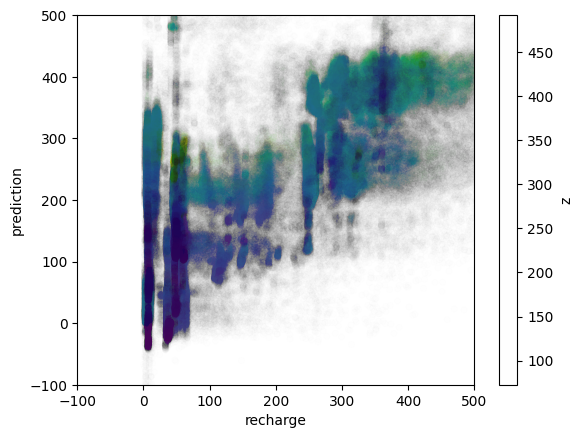

In [35]:
dplt = pd.DataFrame({"recharge": rchg, "prediction": preds, "landuse": lu, "surfgeo": sg, "x": xc, "y": yc, "z": elv})
dplt.plot.scatter(x='recharge',y='prediction',c='z', xlim=(-100,500),ylim=(-100,500), alpha=0.005, legend=None)

# SGRA

> the area annually recharges water to the underlying aquifer at a rate that is greater than the rate of recharge across the whole of the related groundwater recharge area by a factor of 1.15 or more

In [36]:

newrch = np.fromfile("raster/TEGWFM18_regressed_recharge.bil",dtype=np.float32) #.reshape(gdTEGWFM18.shape())

meanrch = np.mean(newrch[np.logical_and(newrch>0, msk>0)])
print(meanrch)

sgra = np.zeros(newrch.shape, dtype=np.int32)
sgra[np.logical_and(newrch>meanrch, msk>0)]=1

sgra.tofile("raster/TEGWFM18_regressed_recharge_sgra.bil")
gdTEGWFM18.saveBitmap("img/TEGWFM18_regressed_recharge_sgra.png", sgra.reshape(gdTEGWFM18.shape()))

190.01965


# Compare with simulated groundwater heads

In [37]:
import flopy.utils.binaryfile as bf
def readHDS(fp, precision='single'):
    f = bf.HeadFile(fp, precision=precision)
    # f.list_records()
    hd = np.array(f.get_data())
    print(hd.shape)
    XX,YY,ZZ = np.meshgrid(np.arange(hd.shape[2]),np.arange(hd.shape[1]),np.arange(hd.shape[0]))
    df = pd.DataFrame(np.vstack((hd.ravel(),XX.ravel(),YY.ravel(),ZZ.ravel())).T)
    df.columns=['h','col','row','lay']
    return(df)

dfYT3 = readHDS("calc/YT3ss_VL_run1/YT3ss_VL_run1.hds")
df2023 = readHDS("calc/YT3ss_VL_run1-2023recharge/YT3ss_VL_run1-2023recharge.hds")
# print(dfYT3)
# print(df2023)

dfmrg = pd.merge(dfYT3, df2023,  how='left', on=['col','row','lay'])
dfmrg = dfmrg[(dfmrg.h_x > -99) & (dfmrg.h_y > -99)]

print(dfmrg)
dfmrg.to_csv('calc/TEGWFM18_regressed_vs_YT3_hds.csv', index=False)

(8, 900, 840)
(8, 900, 840)
                h_x    col    row  lay         h_y
14105    227.350204   83.0    2.0  1.0  227.350204
14106    227.958496   83.0    2.0  2.0  227.864670
14945    227.963303  188.0    2.0  1.0  227.963303
14946    228.144501  188.0    2.0  2.0  228.103256
15784    226.747192  293.0    2.0  0.0  226.747192
...             ...    ...    ...  ...         ...
6031620   82.750000  472.0  897.0  4.0   82.750000
6031621   82.437500  472.0  897.0  5.0   82.437500
6031622   81.849998  472.0  897.0  6.0   81.849998
6032458   82.099998  577.0  897.0  2.0   82.099998
6032459   81.400002  577.0  897.0  3.0   81.400002

[2997784 rows x 5 columns]
